# Black-box Optimization in Python

You've probably noticed that the SciPy optimization routines, and indeed most optimization routines, assume a continuous parameter.  However, there come cases when you would like to use a discrete parameter, such as $n$ in HW4.

There are two different strategies:
1. Pick an optimization method that accepts the parameter as an integer constraint
2. Round the parameter input within the objective function

Either of these strategies work, it is up to you.  Generally strategy 2 is easiest, since you don't need to find a specific algorithm.  Strategy 1 will require an algorithm that supports integer constraints, like `RBFOpt` (these are tricky to install sometimes).

## Black-box (derivative-free) optimization libraries

<!-- Numerical engineers really like to use Fortran, so make sure to install `flang` (Fortran language compiler) first! -->

Some of these packages are broken on Windows in `conda-forge` due to the Fortran compiler required. Numerical engineers tend to use Fortran since it's very close to the applied mathematics. So, you'll have to use `pip` to install rather than `mamba`.

Here are the different libraries that provide black-box optimization:
- `scipy.optimize` (see the differential_evolution() and dual_annealing() functions)
- `PDFO` (Powell's Derivative-Free Optimization)
- `scikit-quant` (aka `skquant`, from Lawrence Berkeley National Laboratory)
- `nevergrad` (Facebook Research's Never Gradient Optimizers)
- `RBFOpt` (IBM Watson's derivative-free optimization)


## Why do we need a special optimizer for integer or black-box optimization?

Short but not technically correct answer: There is no gradient with integers (since integers are not real numbers), so gradient-based methods (most optimization methods) will not work.

The true answer is a bit more complicated.  General functions (black-box functions) are usually nonlinear, so linear optimization functions will not work.  In addition, integer constraints make any optimization problem NP-complete (as in, [nondeterministic-polynomial compute time](https://en.wikipedia.org/wiki/NP-completeness)), so the algorithms that solve these problems are usually special in some transformation of the problem.

## Example using rounding (strategy 2)

We can pretend that we only accept integers for the squaring function, and try to find the minimal x for the square function:

In [1]:
import scipy.optimize
import matplotlib.pyplot as plt
import numpy as np
from typing import Union

In [2]:
def square(a_input: Union[int, float]) -> Union[int, float]:
    a = np.rint(a_input)
    return np.square(a)

We know visually that for the base function $f(x) = x^2$ that $x = 0$ would be the minimal in both real and discrete number spaces.  So let's see if we can verify this with differential evolution:

In [15]:
scipy.optimize.differential_evolution(square, bounds=[(-20, 20)])

     fun: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 122
     nit: 7
 success: True
       x: array([0.47746314])

What are the components of the above output?
- `x`: The optimization's final value for the parameter
- `nfev`: Number of function evaluations
- `nit`: Number of iterations
- `fun`: Value of the objective function at the `x` given

What do these outputs imply?

Let's do a slightly more complex function, such as a function that isn't so smooth.  Let's define a piecewise black-box function:

- If the input $a$ is greater than 3, the output is $a^2 - a$.
- If the input $a$ is less than -1, the output is $a^2 + a$.
- If the input $-1 \le a \le 3$, the output is $a^4 + 10$.

One can see why black-box function optimization is useful -- no assumptions are made about the function.

Let's begin by plotting the function for $-20 \le a \le 20$:

In [16]:
def funny_piecewise(a_in: float) -> float:
    a = np.rint(a_in)
    if a > 3.0:
        return np.power(a, 2) - a
    elif a < -1.0:
        return np.power(a, 2) + a
    else:
        return np.power(a, 4) + 10

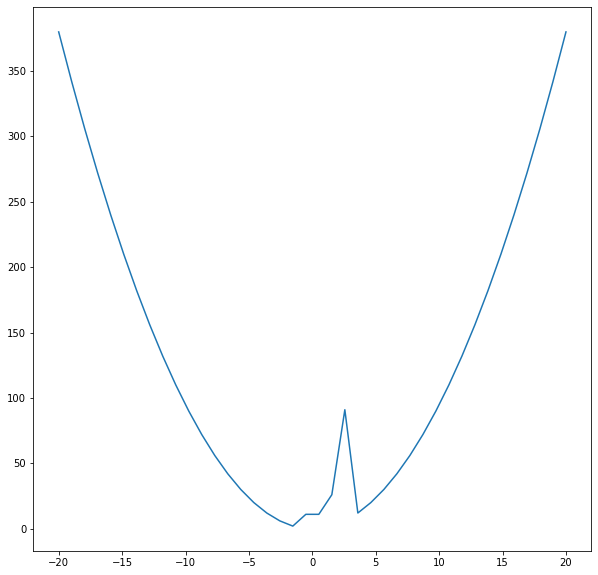

In [20]:
x_range = np.linspace(-20, 20, 40)
y_range = [funny_piecewise(x) for x in x_range]
plt.figure(figsize=(10, 10))
plt.plot(x_range, y_range, label="funny piecewise")

We see now that the minimal is no longer 0, and is probably closer to -2.  Let's use the `differential_evolution()` function to check:

In [49]:
scipy.optimize.differential_evolution(funny_piecewise, bounds=[(-20, 20)])

     fun: 2.0
 message: 'Optimization terminated successfully.'
    nfev: 92
     nit: 5
 success: True
       x: array([-1.91343361])

What do we end up getting?

## Example using `PDFO` on strategy 2

To use the `PDFO` library on Windows, install `PDFO` by running the following in mambaforge prompt: `pip install pdfo`

In [33]:
import pdfo

In [52]:
pdfo.pdfo(funny_piecewise, x0=[-10], bounds=[(-20, 20)])

OptimizeResult(chist=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.]), constrviolation=0.0, fhist=array([ 90.,  72., 110.,  56.,  30.,   2.,  10.,   6.,   2.,   2.,   2.,
         2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.]), fun=2.0, message='Return from bobyqa because the lower bound for the trust region radius is reached.', method='bobyqa', nfev=20, status=0, success=True, x=array([-2.]))

We can see that the PDFO library automatically chooses BOBYQA based on the inputs, and it required only 20 function evaluations to find the minimum at -2.  We can also tell from the `fhist` return that it found this quite a while ago, but probably tried a few different variations around $x = -2$ before finally returning.

## Example using derivative-free methods in `scipy.optimize.minimize()`

In [65]:
scipy.optimize.minimize(funny_piecewise, x0=[-10], bounds=[(-20, 20)], method='Powell')

   direc: array([[1.]])
     fun: array(10.)
 message: 'Optimization terminated successfully.'
    nfev: 58
     nit: 2
  status: 0
 success: True
       x: array([0.26321565])

The Powell method from SciPy doesn't seem to work as well as the true Powell methods in PDFO above.

In [66]:
constraints = [
    {'type': 'ineq', 'fun': lambda x: x - -20},
    {'type': 'ineq', 'fun': lambda x: 20 - x}
]

scipy.optimize.minimize(funny_piecewise, x0=[-10], constraints=constraints, method='COBYLA')

     fun: 2.0
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 15
  status: 1
 success: True
       x: array([-2.])

However, COBYLA (which is also inside PDFO), seems to work pretty well.  The syntax is a little odd in terms of describing the bounds, since COBYLA can only take constraints (no bounds).